# Reinforcement Learning Exercise

For this exercise we will be using the [OpenAI Gym](https://gym.openai.com/) provided by [OpenAI](https://openai.com/). To get to know Gym, you are encouraged to read this [blogpost](https://openai.com/blog/openai-gym-beta/) (~10 minutes) and refer to the [docs](https://gym.openai.com/docs) along the way.

In this exercise we will train a neural network agent to navigate various environments from the OpenAI Gym.

## 0. Prerequisites

We assume you already have Theano and Lasagne installed -- otherwise go back to the first exercise for instructions. 

Below is a brief guide on how to install OpenAI Gym. For more details please refer to the [docs](https://gym.openai.com/docs).
   
```
$ cd ~/path/to/dir/...
$ git clone https://github.com/openai/gym
$ cd gym
$ pip install -e . # minimal install
```

Verify your installation is working by importing `gym` and check for errors:

```
$ python
>>> import gym
[no errors]
```

Now restart this notebook before moving on to the next part.

## 1. Getting started

Now that you have everythong installed, lets get started!

The code below will import `gym` and initialize the [CartPole-v0](https://gym.openai.com/envs/CartPole-v0) environment. The task of this environment is to move a cart in order to balance a pole attached on top, but for now we will just take random actions for 200 timesteps to see what happens. The environment is rendered in a separate window so you can observe the result. 

In [74]:
import gym

# init and run an example environment
env = gym.make('CartPole-v0')
env.reset()
for _ in range(200):
    env.render()
    env.step(env.action_space.sample())
env.render(close=True)

[2016-10-03 13:21:08,793] Making new env: CartPole-v0
[2016-10-03 13:21:08,878] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


That was all very nice, but taking random actions doesn't really solve the task. We have to do something smarter. In the next part we will train an agent to solve the task by reinforcement learning.

## 2. Policy gradient agent

In this part we will create an agent that can learn to solve tasks from OpenAI Gym by applying the policy gradient method.

The agent is designed to work on environments with a discrete action space. Extending the code to also handle environments with countinous action space is left as an optional exercise.

But first here is a short introduction to policy gradients.

### Policy gradients

We want to learn a policy neural network $p_\theta(a_{t}|s_{t-1})$ with parameters $\theta$ for action $a_t$ given the previous state $s_{t-1}$ only.
When the action $a$ is discrete we can implement this by a softmax output taking $s$ as input. 
The (discounted) cumulative award for a sequence terminating after $T$ time-steps is

$$
R = \sum_{t=1}^T \gamma^{t-1} r_{t} \ .
$$

The expectation of $R$ over a
policy roll-out $p_\theta({\bf a}|{\bf s})$ is 

$$
\mathbb{E}[R|\theta] = \int R({\bf a},{\bf s}) p_\theta({\bf a},{\bf s}) d{\bf a} d{\bf s}\ ,
$$

where ${\bf a} = a_1,\ldots,a_T$, ${\bf s}=s_0,\ldots,s_T$ and

$$
p_\theta({\bf a},{\bf s}) = p(s_0) \prod_{t=1}^T \left[ 
p(s_{t}|s_{t-1},a_t) p_\theta(a_{t}|s_{t-1})
\right]\ .
$$

In this formulation $s_t$ is a stochastic function of the previous action and state: $p(s_t|a_t,s_{t-1})$. We can draw from the joint distribution of actions and states through the environment but $p(s_t|a_t,s_{t-1})$ is unknown. 

A deterministic environment, think chess or go, is a special case of this set-up where the state is a deterministic function of the previous state and action: $s_t = f(a_t,s_{t-1})$. We can include the deterministic formulation in the general by using a Dirac $\delta$-function: $p(s_t|a_t,s_{t-1})= \delta(s_t - f(a_t,s_{t-1}))$. The integration over $s_1,\ldots,s_T$ may be carried out explicitly:    

$$
\mathbb{E}[R|\theta] = \int R({\bf a},s_0) p(s_0) \prod_{t=1}^T  p_\theta(a_{t}|s_{t-1})d{\bf a} ds_0\ ,
$$

where $s_{t-1}=f(a_{t-1},s_{t-2})$.

We use gradient ascent to learn an approximation to a policy that maximizes the cumulative reward. 
So we need to compute the gradient:

$$
\nabla_\theta \mathbb{E}[R|\theta] = \int R({\bf a}, {\bf s}) \nabla_\theta p_\theta({\bf a},{\bf s}) \, d{\bf a}d{\bf s} \ .
$$

We can now use the identity

$$
\nabla_\theta p_\theta({\bf a},{\bf s}) = p_\theta({\bf a},{\bf s}) \nabla_\theta \log p_\theta({\bf a},{\bf s})
$$

to express the gradient as an average over $p_\theta({\bf a},{\bf s})$:

$$
\nabla_\theta \mathbb{E}[R|\theta] = \int p_\theta({\bf a},{\bf s}) ( R({\bf a}, {\bf s}) - b ) \nabla_\theta \log p_\theta({\bf a},{\bf s}) d{\bf a}d{\bf s}\ .
$$

The constant factor $b$ will not affect the gradient but will needed in practice when we estimate gradients by Monte Carlo (that is roll-outs). We can prove that subtracting $b$ will not change the gradient by using the identity from above again:

\begin{align*}
0 & = \nabla_\theta 1 \\
  & = \nabla_\theta \int p_\theta({\bf a},{\bf s}) \, d{\bf a} d{\bf s}\\
  & = \int \nabla_\theta p_\theta({\bf a},{\bf s}) \, d{\bf a}d{\bf s}\\
  & = \int p_\theta({\bf a},{\bf s}) \nabla_\theta \log p_\theta({\bf a},{\bf s}) \, d{\bf a}d{\bf s} \ .
\end{align*}

We cannot evaluate the average over roll-outs analytically but we have an environment simulator that when supplied with our current policy $p_\theta(a|s)$ can return the sequence of action, states and rewards. This allows us to replace the integral by a Monte Carlo average over $V$ roll-outs

$$
\nabla_\theta \mathbb{E}[R|\theta] \approx \frac{1}{V} \sum_{v=1}^V ( R({\bf a}^{(v)}, {\bf s}^{(v)}) - b) \nabla_\theta \log p_\theta({\bf a}^{(v)},{\bf s}^{(v)})
$$

Note also that the gradient of $\log p_\theta({\bf a}^{(v)},{\bf s}^{(v)})$ does not depend explicitly on the state distribution:

$$
\nabla_\theta \log p_\theta({\bf a}^{(v)},{\bf s}^{(v)}) = \sum_{t=1}^T \nabla_\theta \log p_\theta(a_{t}|s_{t-1}) \ .
$$

We are almost done. As a last step we will use the freedom in the choice of $b$ to select a $b$ that will make the Monte Carlo estimate of the gradient have the lowest possible variance. In other words, the finite Monte Carlo sample give us a noisy gradient and by this correction we can make it vary as little as possible between roll-out draws.

The $b$ that minimizes the variances can be found from minimizing the following expression:

$$
\int p_\theta({\bf a},{\bf s}) \, ( R({\bf a}, {\bf s}) - b )^2 \,  |\nabla_\theta \log p_\theta({\bf a},{\bf s})|^2 \,  d{\bf a}d{\bf s} - \left( \nabla_\theta \mathbb{E}[R|\theta] \right)^2 \ .
$$

The solution to this problem is

$$
b = \frac{\int p_\theta({\bf a},{\bf s}) \, R({\bf a}, {\bf s}) \,  |\nabla_\theta \log p_\theta({\bf a},{\bf s})|^2 d{\bf a}d{\bf s}}{\int p_\theta({\bf a},{\bf s}) \, |\nabla_\theta \log p_\theta({\bf a},{\bf s})|^2 d{\bf a}d{\bf s}} \ .
$$

We replace this expression by a Monte Carlo average:

$$
b = \frac{\sum_{v=1}^V  R({\bf a}^{(v)}, {\bf s}^{(v)}) \, |\nabla_\theta \log p_\theta({\bf a}^{(v)},{\bf s}^{(v)})|^2}{\sum_{v=1}^V | \nabla_\theta \log p_\theta({\bf a}^{(v)},{\bf s}^{(v)})|^2}
$$

In the code below we instead use a time-step dependent baseline correction, $b(s_t)$, as described in [here](https://gym.openai.com/docs/rl#policy-gradients).

In [75]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import theano
import theano.tensor as T
import lasagne
from lasagne.layers import InputLayer, DenseLayer
from lasagne.nonlinearities import tanh, softmax

In [220]:
class Agent(object):
    """
    Reinforcement Learning Agent
    
    This agent can learn to solve reinforcement learning tasks from
    OpenAI Gym by applying the policy gradient method.
    """

    def __init__(self, n_inputs, n_outputs):
        # symbolic variables for state, action, and advantage
        sym_state = T.fmatrix()
        sym_action = T.ivector()
        sym_advantage = T.fvector()
        # policy network
        l_in = InputLayer(shape=(None, n_inputs))
        l_hid = DenseLayer(incoming=l_in, num_units=20, nonlinearity=tanh, name='hiddenlayer')
        l_out = DenseLayer(incoming=l_hid, num_units=n_outputs, nonlinearity=softmax, name='outputlayer')
        # get network output
        eval_out = lasagne.layers.get_output(l_out, {l_in: sym_state}, deterministic=True)
        # get trainable parameters in the network.
        params = lasagne.layers.get_all_params(l_out, trainable=True)
        # get total number of timesteps
        t_total = sym_state.shape[0]
        # loss function that we'll differentiate to get the policy gradient
        loss = -T.log(eval_out[T.arange(t_total), sym_action]).dot(sym_advantage) / t_total
        # learning_rate
        learning_rate = T.fscalar()
        # get gradients
        grads = T.grad(loss, params)
        # update function
#         updates = lasagne.updates.adagrad(grads, params, learning_rate=learning_rate)
        updates = lasagne.updates.momentum(grads, params,learning_rate=learning_rate)
        
        #New optimizer
#         updates = lasagne.updates.sgd(grads, params, learning_rate=learning_rate)
        # declare training and evaluation functions
        self.f_train = theano.function([sym_state, sym_action, sym_advantage, learning_rate], loss, updates=updates, allow_input_downcast=True)
        self.f_eval = theano.function([sym_state], eval_out, allow_input_downcast=True)
    
    def learn(self, env, n_epochs=100, t_per_batch=10000, traj_t_limit=None,
              learning_rate=0.1, discount_factor=1.0, n_early_stop=0):
        """
        Learn the given environment by the policy gradient method.
        """
        self.mean_train_rs = []
        self.mean_val_rs = []
        self.loss = []
        for epoch in xrange(n_epochs):
            # 1. collect trajectories until we have at least t_per_batch total timesteps
            trajs = []; t_total = 0
            while t_total < t_per_batch:
                traj = self.get_trajectory(env, traj_t_limit, deterministic=False)
                trajs.append(traj)
                t_total += len(traj["r"])
            all_s = np.concatenate([traj["s"] for traj in trajs])
            # 2. compute cumulative discounted rewards (returns)
            rets = [self._cumulative_discount(traj["r"], discount_factor) for traj in trajs]
            maxlen = max(len(ret) for ret in rets)
            padded_rets = [np.concatenate([ret, np.zeros(maxlen-len(ret))]) for ret in rets]
            # 3. compute time-dependent baseline
            baseline = np.mean(padded_rets, axis=0)
            # 4. compute advantages
            advs = [ret - baseline[:len(ret)] for ret in rets]
            all_a = np.concatenate([traj["a"] for traj in trajs])
            all_adv = np.concatenate(advs)
            # 5. do policy gradient update step
            loss = self.f_train(all_s, all_a, all_adv, learning_rate)
            train_rs = np.array([traj["r"].sum() for traj in trajs]) # trajectory total rewards
            eplens = np.array([len(traj["r"]) for traj in trajs]) # trajectory lengths
            # compute validation reward
            val_rs = np.array([self.get_trajectory(env, traj_t_limit, deterministic=True)['r'].sum() for _ in range(10)])
            # update stats
            self.mean_train_rs.append(train_rs.mean())
            self.mean_val_rs.append(val_rs.mean())
            self.loss.append(loss)
            # print stats
            print '%3d mean_train_r: %6.2f mean_val_r: %6.2f loss: %f' % (epoch+1, train_rs.mean(), val_rs.mean(), loss)
            # render solution
            #self.get_trajectory(env, traj_t_limit, render=True)
            # check for early stopping: true if the validation reward has not changed in n_early_stop epochs
            if n_early_stop and len(self.mean_val_rs) >= n_early_stop and \
                all([x == self.mean_val_rs[-1] for x in self.mean_val_rs[-n_early_stop:-1]]):
                break
    
    def get_trajectory(self, env, t_limit=None, render=False, deterministic=True):
        """
        Compute trajectroy by iteratively evaluating the agent policy on the environment.
        """
        t_limit = t_limit or env.spec.timestep_limit
        s = env.reset()
        traj = {'s': [], 'a': [], 'r': [],}
        for _ in xrange(t_limit):
            a = self.get_action(s, deterministic)
            (s, r, done, _) = env.step(a)
            traj['s'].append(s)
            traj['a'].append(a)
            traj['r'].append(r)
            if render: env.render()
            if done: break
        return {'s': np.array(traj['s']), 'a': np.array(traj['a']), 'r': np.array(traj['r'])}
    
    def get_action(self, s, deterministic=True):
        """
        Evaluate the agent policy to choose an action, a, given state, s.
        """
        # compute action probabilities
        prob_a = self.f_eval(s.reshape(1,-1))
        if deterministic:
            # choose action with highest probability
            return prob_a.argmax()
        else:
            # sample action from distribution
            return (np.cumsum(np.asarray(prob_a)) > np.random.rand()).argmax()
    
    def _cumulative_discount(self, r, gamma):
        """
        Compute the cumulative discounted rewards (returns).
        """
        r_out = np.zeros(len(r), 'float64')
        r_out[-1] = r[-1]
        for i in reversed(xrange(len(r)-1)):
            r_out[i] = r[i] + gamma * r_out[i+1]
        return r_out

Now that we have an agent, let's train it to solve the CartPole task.

Note: The agent is not guaranteed to learn a good solution every time as the policy gradient method might get stuck in a local optimum -- you may have to do several restarts to find a good solution.

In [231]:
# init environment
env = gym.make('CartPole-v0')
# init agent
agent = Agent(n_inputs=env.observation_space.shape[0],
              n_outputs=env.action_space.n)
# train agent on the environment
# agent.learn(env, n_epochs=100, learning_rate=0.05, discount_factor=1,
#             t_per_batch=1000, traj_t_limit=env.spec.timestep_limit, n_early_stop=5)
#1
# agent.learn(env, n_epochs=100, learning_rate=0.05, discount_factor=1,
#             t_per_batch=1000, traj_t_limit=500, n_early_stop=5)
# This converged but had some ups and downs
#agent.learn(env, n_epochs=100, learning_rate=0.1, discount_factor=0.99,
#             t_per_batch=10000, traj_t_limit=200, n_early_stop=5)
agent.learn(env, n_epochs=100, learning_rate=0.009, discount_factor=0.99,
            t_per_batch=10000, traj_t_limit=200, n_early_stop=5)

[2016-10-03 15:03:55,310] Making new env: CartPole-v0


  1 mean_train_r:  22.37 mean_val_r:  15.30 loss: 1.798372
  2 mean_train_r:  22.28 mean_val_r:  16.10 loss: 2.077622
  3 mean_train_r:  21.99 mean_val_r:  21.50 loss: 1.984454
  4 mean_train_r:  22.60 mean_val_r:  13.60 loss: 1.839973
  5 mean_train_r:  23.23 mean_val_r:  14.20 loss: 2.180260
  6 mean_train_r:  22.24 mean_val_r:  16.50 loss: 2.102077
  7 mean_train_r:  21.66 mean_val_r:  12.80 loss: 1.787246
  8 mean_train_r:  21.84 mean_val_r:  12.30 loss: 1.728649
  9 mean_train_r:  22.08 mean_val_r:  11.40 loss: 2.072387
 10 mean_train_r:  21.39 mean_val_r:  10.30 loss: 1.904222
 11 mean_train_r:  21.75 mean_val_r:  10.20 loss: 1.644869
 12 mean_train_r:  22.26 mean_val_r:  10.00 loss: 2.058515
 13 mean_train_r:  22.25 mean_val_r:   9.50 loss: 1.753781
 14 mean_train_r:  21.65 mean_val_r:   9.80 loss: 1.835190
 15 mean_train_r:  20.52 mean_val_r:   9.40 loss: 1.708571
 16 mean_train_r:  21.22 mean_val_r:   9.20 loss: 1.824530
 17 mean_train_r:  20.77 mean_val_r:   9.40 loss: 1.5528

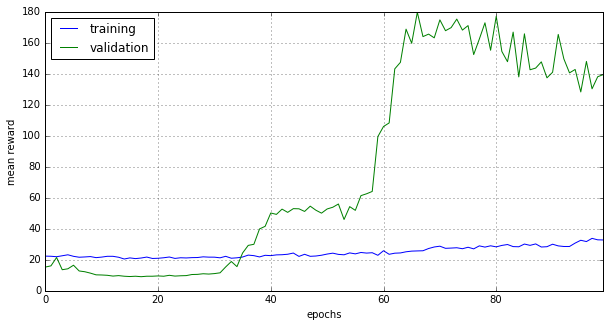

ValueError: Format "01" is not supported.
Supported formats: eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff.

In [232]:
# plot training and validation mean reward
plt.figure(figsize=(10,5))
plt.xlabel('epochs'); plt.ylabel('mean reward')
plt.plot(agent.mean_train_rs, label='training')
plt.plot(agent.mean_val_rs, label='validation')
plt.xlim((0,len(agent.mean_val_rs)-1))
plt.legend(loc=2); plt.grid()
_=plt.show()
plt.savefig("Momentum_0.png")

In [208]:
# review solution

agent.get_trajectory(env, t_limit=10000, render=True)
env.render(close=True)

The initial solution does not learn to solve the task very well. Here are some hints on how to improve the solution:

* Increase the trajectory timestep limit to let the simulations look further into the future.
* Increase number of timesteps evaluated per batch.
* Try different optimization functions.
* Adjust the learning rate.
* Adjust the discount factor.

### Exercises

1. Describe the changes you made and and why they should improve the agent. Are you able to get solutions consistently?
2. In the plot above you will sometimes see that the validation reward starts out lower than the training reward but later they cross. How can you explain this behavior?
3. Explain step by step the algorithm in the `agent.learn` method with particular attention the points denoted 1-5 in the code above.
4. Optional: Monitor and submit your best solution to the Gym (see code below).

In [ ]:
#By decreasing the number of timesteps per batch it was possible to get a solution by updating into the solution
#But it seemed very unstable
#Adam Optimization was pretty not converging consistantly i think it is because when it is building momentum it overshoots
#2.
#

In [88]:
# start monitor
# env.monitor.start('cartpole-experiment-1')
# for _ in xrange(100):
#    agent.get_trajectory(env)
# env.monitor.close()

When you have monitored a solution open a Python shell and use the following command to upload the results to OpenAI Gym:

```
import gym
gym.upload('cartpole-experiment-1', api_key='YOUR_API_KEY')
```

You can also run the command here in the notebook, but remember to remove the API key before handing in the exercise.

You can find your API key at your [OpenAI Gym](https://gym.openai.com/) account page. 

## 3. Playground

In this part you can try to learn a solution to an environment from [OpenAI Gym](https://gym.openai.com/) of your own choice. Some environments will require you to adjust the agent code since they have different properties, however, some environments such as 'Acrobot-v1' and 'MountainCar-v0' should work out of the box.

Below is some code to get you started.

### Exercises

1. Describe the environment you have chosen including its state and action space.
2. Describe the particular challanges of the environment you have chosen.
3. Were you able to train a good solution? How/why not?
4. Optional: Monitor and submit your solution to the Gym.

In [ ]:
# init environment
#my_env = gym.make('some-environment')
# init agent
#my_agent = Agent(n_inputs=my_env.observation_space.shape[0],
#              n_outputs=my_env.action_space.n)
# train agent on the environment
#my_agent.learn(my_env)

In [ ]:
# plot training and validation mean reward
#plt.figure(figsize=(10,5))
#plt.xlabel('epochs'); plt.ylabel('mean reward')
#plt.plot(my_agent.mean_train_rs, label='training')
#plt.plot(my_agent.mean_val_rs, label='validation')
#plt.xlim((0,len(my_agent.mean_val_rs)-1))
#plt.legend(loc=2); plt.grid()
#_=plt.show()

In [ ]:
# review solution
#my_agent.get_trajectory(my_env, t_limit=1000, render=True)
#my_env.render(close=True)

## 4. Optional exercises

1. Optional: Extend the agent to also work on environments with a continous action space.